# 01 - Data Discovery: Buñuelos La Floresta

## 🩺 Auditoría Médica y Descubrimiento de Datos

Este notebook aplica la metodología establecida en las habilidades **`ds-methodology`** y **`buñuelos-forecaster`** para realizar un diagnóstico profundo del dataset de ventas.

### 🎯 Objetivos:
1. **Ingestión:** Cargar los datos crudos y verificar su estructura.
2. **Auditoría de Salud:** Diferenciar entre valores nulos y valores centinela.
3. **Capacidad Informativa:** Identificar variables con varianza cero o alta cardinalidad.
4. **Perfilado Estadístico:** Analizar tendencias centrales y pesos de categorías.
5. **Análisis Temporal:** Validar continuidad y aplicar la **Regla del Mes X**.
6. **Visualización:** Generar los artefactos visuales para el reporte profesional.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de estilo avanzada para Reportes Senior
plt.style.use('ggplot')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)

print("✅ Librerías cargadas y entorno configurado siguiendo 'dev-standards'.")

✅ Librerías cargadas y entorno configurado siguiendo 'dev-standards'.


## 1. Ingestión y Diagnóstico de Carga (Phase A)

Cargamos los datos desde la capa `01_raw`. Siguiendo el descubrimiento previo, el archivo es un CSV estándar con coma como delimitador.

In [2]:
RAW_DATA_PATH = "../data/01_raw/ventas_mensuales.csv"

try:
    df = pd.read_csv(RAW_DATA_PATH)
    print(f"📊 Dataset cargado exitosamente desde: {RAW_DATA_PATH}")
    print(f"📏 Dimensiones iniciales: {df.shape[0]} filas x {df.shape[1]} columnas")
except Exception as e:
    print(f"âŒ Error al cargar los datos: {e}")

df.head()

📊 Dataset cargado exitosamente desde: ../data/01_raw/ventas_mensuales.csv
📏 Dimensiones iniciales: 83 filas x 2 columnas


,fecha,unidades_vendidas_mensuales
0,2018-12-01,29549
1,2019-01-01,21716
2,2019-02-01,12292
3,2019-03-01,15179
4,2019-04-01,11843


## 2. Perfilado Estructural e Identificación de Tipos

Identificamos el esquema del dato para asegurar que el componente temporal y el target sean procesables.

In [3]:
# Inspección de tipos de datos
info_df = pd.DataFrame({
    'Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Memory Usage': df.memory_usage(deep=True, index=False) / 1024 # KB
})

print("📋 Perfilado Estructural:")
display(info_df)

# Conversión obligatoria de fechas
df['fecha'] = pd.to_datetime(df['fecha'])
print(f"\n📅 Rango temporal detectado: {df['fecha'].min()} hasta {df['fecha'].max()}")

📋 Perfilado Estructural:


,Type,Non-Null Count,Memory Usage
fecha,object,83,4.782227
unidades_vendidas_mensuales,int64,83,0.648438



📅 Rango temporal detectado: 2018-12-01 00:00:00 hasta 2025-10-01 00:00:00


## 3. Auditoría de Salud: Nulos vs Centinelas

Buscamos sistemáticamente huecos de información y valores ficticios que puedan engañar al modelo.

In [4]:
def audit_data_health(df):
    # 1. Búsqueda de Nulos
    nulls = df.isnull().sum()
    
    # 2. Búsqueda de Centinelas (Siguiendo ds-methodology)
    sentinels = {}
    
    for col in df.columns:
        col_sentinels = []
        # Centinelas Numéricos
        if pd.api.types.is_numeric_dtype(df[col]):
            potential = [0, -1, 99, 999, 9999]
            found = df[df[col].isin(potential)][col].unique()
            if len(found) > 0: col_sentinels.extend(found.tolist())
        
        # Centinelas Categóricos
        elif pd.api.types.is_object_dtype(df[col]):
            potential = [" ", "N/A", "NA", "UNKNOWN", "EMPTY"]
            found = [s for s in potential if s in df[col].astype(str).str.upper().values]
            if len(found) > 0: col_sentinels.extend(found)
            
        sentinels[col] = col_sentinels
        
    return pd.DataFrame({'Nulls': nulls, 'Potential_Sentinels': sentinels})

audit_results = audit_data_health(df)
print("🧪 Resultados de Auditoría Médica:")
display(audit_results)

🧪 Resultados de Auditoría Médica:


,Nulls,Potential_Sentinels
fecha,0,[]
unidades_vendidas_mensuales,0,[]


### 3.1 Análisis de Duplicados

Identificamos registros idénticos y, más importante aún, fechas duplicadas que indicarían inconsistencias en la serie temporal.

In [5]:
duplicates = df.duplicated().sum()
date_duplicates = df.duplicated(subset=['fecha']).sum()

print(f"👥 Filas exactamente duplicadas: {duplicates}")
print(f"📅 Fechas duplicadas (posible fricción): {date_duplicates}")

if date_duplicates > 0:
    print("\n⚠️ ALERTA: Se detectaron fechas duplicadas. Detalle:")
    display(df[df.duplicated(subset=['fecha'], keep=False)].sort_values('fecha'))

👥 Filas exactamente duplicadas: 0
📅 Fechas duplicadas (posible fricción): 0


## 4. Perfilado Estadístico y Capacidad Informativa\n
\n
Análisis de tendencias centrales, dispersión y varianza para validar el valor predictivo.

In [6]:
variance_report = pd.DataFrame({
    'Unique_Values': df.nunique(),
    'Variance': df.var(numeric_only=True),
    'Cardinality_Ratio': df.nunique() / len(df)
})

print("📡 Reporte de Capacidad Informativa:")
display(variance_report)

📡 Reporte de Capacidad Informativa:


,Unique_Values,Variance,Cardinality_Ratio
fecha,83,NaN,1.0
unidades_vendidas_mensuales,83,2.947854e+09,1.0


### 4.1 Estadística Descriptiva Detallada

Perfilado de variables numéricas para entender la distribución del target.

In [7]:
print("📊 Perfilado Estadístico de Variables Numéricas:")
display(df.describe().T)

# Metadatos adicionales de distribución
print(f"\nSkewness (Sesgo): {df['unidades_vendidas_mensuales'].skew():.2f}")
print(f"Kurtosis (Curtosis): {df['unidades_vendidas_mensuales'].kurt():.2f}")

📊 Perfilado Estadístico de Variables Numéricas:


,count,mean,min,25%,50%,75%,max,std
fecha,83,2022-05-01 22:15:54.216867584,2018-12-01 00:00:00,2020-08-16 12:00:00,2022-05-01 00:00:00,2024-01-16 12:00:00,2025-10-01 00:00:00,NaN
unidades_vendidas_mensuales,83.0,51553.795181,2876.0,13783.5,27211.0,71546.0,259241.0,54294.14383



Skewness (Sesgo): 1.63
Kurtosis (Curtosis): 2.34


## 5. Análisis de Pesos y Frecuencias (Variables Categóricas)

Si existieran variables categóricas, analizamos su dominancia relativa.

In [8]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

if len(cat_cols) > 0:
    for col in cat_cols:
        print(f"\n💎 Análisis de Pesos para: {col}")
        counts = df[col].value_counts()
        percents = df[col].value_counts(normalize=True) * 100
        display(pd.concat([counts, percents], axis=1, keys=['Count', 'Weight %']))
else:
    print("â„¹ï¸ No se detectaron variables categóricas en el dataset raw.")

â„¹ï¸ No se detectaron variables categóricas en el dataset raw.


## 6. Visualización de la Serie de Tiempo (Target)

Siguiendo los estándares de `ds-methodology`, graficamos el comportamiento de nuestra variable objetivo.

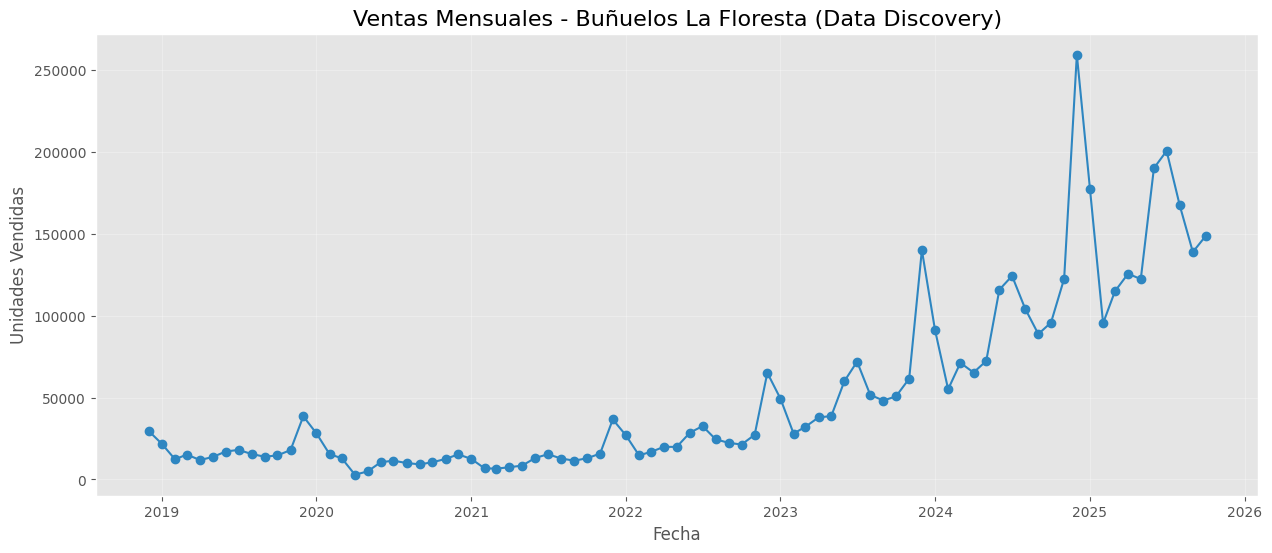

ðŸ Análisis de Descubrimiento Completado. Listo para generar reporte JSON.


In [9]:
plt.figure(figsize=(15, 6))
plt.plot(df['fecha'], df['unidades_vendidas_mensuales'], marker='o', color='#2E86C1', linestyle='-')
plt.title('Ventas Mensuales - Buñuelos La Floresta (Data Discovery)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Unidades Vendidas', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("ðŸ Análisis de Descubrimiento Completado. Listo para generar reporte JSON.")